In [1]:
import os
import sys
import glob
import time
import numpy  as np
import pandas as pd

import zfit
import hist
from scipy.interpolate import interp1d

from invisible_cities.evm.mixer import get_file_number
from invisible_cities.io.dst_io import load_dst, load_dsts
from invisible_cities.core.system_of_units import keV, MeV, mBq, year
from invisible_cities.database.load_db import RadioactivityData

%matplotlib ipympl
import matplotlib.pyplot as plt

plt.rcParams["font.size"]      = 10
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"
plt.rcParams["figure.max_open_warning"] = False

/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/zfit/__init__.py:50: UserWarning: This is an ALPHA version of zfit for feature testing, do NOT use it in production! It is NOT stable and contains bugs and untested features. For production use, please use the last beta stable version of zfit.
  warnings.warn(
/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/zfit/__init__.py:62: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
def load_dsts_with_info(filenames, group, table):
    
    get_volume = lambda filename: filename.split("/")[-4]
    
    dst = pd.DataFrame()
    for f, filename in enumerate(filenames, 1):
        print(f"Processed {f} / {len(filenames)}", end="\r")
        try:
            dst_ = load_dst(filename, group, table)
        except:
            #print(filename)
            continue
        dst_.loc[:, "file"]     = get_file_number(filename)
        dst_.loc[:, "G4Volume"] = get_volume(filename)
        dst = pd.concat([dst, dst_])
    print()
    return dst


def remove_spurious_tracks(tracks, spurious_energy):
    # remove spurious tracks and assign energy to largest energy track:
    # sum spurious track energies to max energy track and
    # correct numb_of_tracks values

    # tracks index must be (event, file) (ie levels 0 and 1)
    tracks = tracks.set_index("trackID", append=True)

    sel_spurious = (tracks.energy < spurious_energy)
    spurious_energies = tracks.loc[sel_spurious].groupby(level=[0, 1]).energy.sum()

    # trackID of max energy track
    trackID = tracks.reset_index(level=2).loc[spurious_energies.index] \
                    .set_index("trackID", append=True).groupby(level=[0, 1]) \
                    .apply(lambda df: df.energy.idxmax()[-1])
    trackID.name = "trackID"

    # sum spurious energy to max energy track
    spurious_energies = pd.merge(spurious_energies, trackID, left_index=True, right_index=True)\
                        .set_index("trackID", append=True)
    tracks.loc[spurious_energies.index, "energy"] += spurious_energies.energy

    # drop spurious
    tracks = tracks.loc[~sel_spurious].reset_index("trackID")
    # correct numb of tracks
    tracks.loc[:, "numb_of_tracks"] = tracks.groupby(level=[0, 1]).trackID.nunique()

    return tracks


def apply_cuts(tracks):
    
    # cuts

    # 1S1-1S2
    # included

    # spurious tracks
    tracks = remove_spurious_tracks(tracks.set_index(["event", "file"]), 0.01)

    # 1-track
    sel = tracks.numb_of_tracks == 1
    print("1track eff:", round(tracks.loc[sel].index.nunique()/tracks.index.nunique(), 3))
    tracks = tracks.loc[sel]

    # fiducial R<rmax
    sel = tracks.r_max<450
    print("fiducial eff:", round(tracks.loc[sel].index.nunique()/tracks.index.nunique(), 3))
    tracks = tracks.loc[sel]

    # overlap
    sel = tracks.ovlp_blob_energy == 0
    print("overlap eff:", round(tracks.loc[sel].index.nunique()/tracks.index.nunique(), 3))
    tracks = tracks.loc[sel]
    
#     # E > 2 MeV
#     tracks = tracks[tracks.energy>2]
    
    return tracks

In [3]:
inpath = os.path.expandvars("$HOME/NEXT/DATA/production/{isotope}/{g4volume}/prod/isaura/isaura_*.h5")

In [4]:
isotope  = "208Tl"

filenames = sorted( glob.glob(inpath.format(isotope=isotope, g4volume="*"))
                  , key = get_file_number)[:2000]

t0 = time.time()

tracks = load_dsts_with_info(filenames, "Tracking", "Tracks")
tracks = apply_cuts(tracks)

print()
print("Time:", (time.time() - t0) / 60)

Processed 2000 / 2000
1track eff: 0.694
fiducial eff: 0.786
overlap eff: 0.991

Time: 1.799315885702769


In [45]:
energy_obs_ext = zfit.Space("energy", limits=(2.00, 2.70))
energy_obs     = zfit.Space("energy", limits=(2.30, 2.70))

# kde
data    = zfit.Data.from_numpy (obs=energy_obs_ext, array=tracks.energy.values)
pdf_kde = zfit.pdf.KDE1DimGrid(obs=energy_obs, data=data, bandwidth="adaptive_zfit", num_grid_points=10000)

# binned
bins = np.arange(*energy_obs.limit1d, 0.005)
h, _ = np.histogram(tracks.energy.values, bins=bins)
h = hist.Hist(hist.axis.Variable(edges=bins, name="E"), data=h)
pdf_hist = zfit.pdf.HistogramPDF(h)

/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/zfit/core/binning.py:88: UserWarning: Flow currently not fully supported. Values outside the edges are all 0.
  warnings.warn(


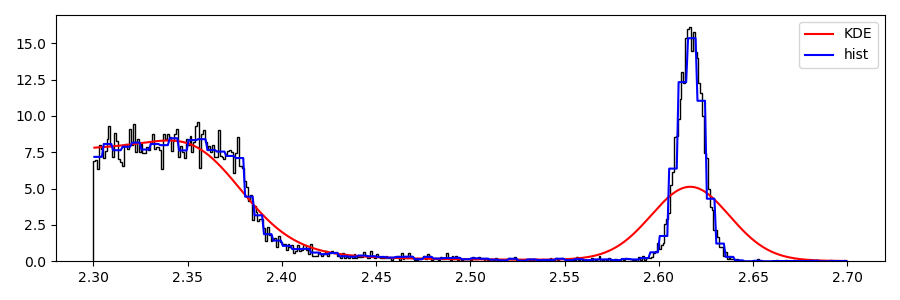

In [46]:
plt.figure(figsize=[9, 3])

bins = np.arange(*energy_obs.limit1d, 0.001)
binc = (bins[1:] + bins[:-1])/2.

plt.hist(tracks.energy.values, bins=bins, color="k", density=True, histtype="step")
plt.plot(binc, pdf_kde .pdf(binc), c="r", label="KDE")
plt.plot(binc, pdf_hist.pdf(binc), c="b", label="hist")

plt.legend()
plt.tight_layout();

In [4]:
inpath = os.path.expandvars("$HOME/NEXT/DATA/production/{isotope}/{g4volume}/prod/isaura/isaura_*.h5")

In [8]:
isotope  = "208Tl"
g4volume = "ICS"

filenames = sorted( glob.glob(inpath.format(isotope=isotope, g4volume=g4volume))
                  , key = get_file_number)[:1000]

t0 = time.time()

tracks = load_dsts_with_info(filenames, "Tracking", "Tracks")
# dsts   = load_dsts_with_info(filenames,      "DST", "Events")
print()

tracks = apply_cuts(tracks)
exec(f"tracks_{g4volume} = tracks")

# dsts   = dsts.set_index(["event", "file"]).loc[tracks.index]
# exec(f"dsts_{g4volume} = dsts")

print()
print("Time:", (time.time() - t0) / 60)

Processed 1000 / 1000

1track eff: 0.704
fiducial eff: 0.771
overlap eff: 0.992

Time: 1.2403381665547688


In [6]:
tracks.columns

Index(['trackID', 'energy', 'length', 'numb_of_voxels', 'numb_of_hits',
       'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max',
       'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z', 'G4Volume'],
      dtype='object')

NameError: name 'tracks_ICS' is not defined

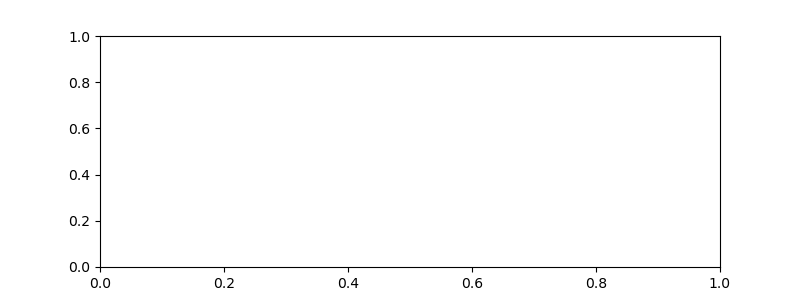

In [7]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)

density = True
var = "eblob2"
bins = np.arange(0, 0.5, 0.003)
# var = "energy"
# bins= np.arange(2.55, 2.65, 0.001)


ax.hist(tracks_ICS[var], bins=bins, histtype="step", label="0", density=density)

# high Z
ax.hist(tracks_EP_COPPER_PLATE[var], bins=bins, histtype="step", label="3", density=density)


ax.set_xlabel("Energy (MeV)")
ax.legend()
fig.tight_layout();

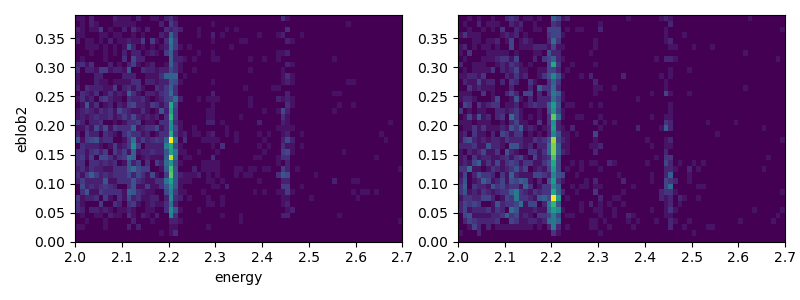

In [33]:
varx = "energy"
vary = "eblob2"

xbins = np.arange(2, 2.7, 0.01)
ybins = np.arange(0, 0.4, 0.01)

plt.figure(figsize=[8, 3])

plt.subplot(121)
plt.xlabel(varx)
plt.ylabel(vary)
plt.hist2d(tracks_ICS[varx], tracks_ICS[vary], bins=[xbins, ybins])

plt.subplot(122)
plt.hist2d(tracks_EP_COPPER_PLATE[varx], tracks_EP_COPPER_PLATE[vary], bins=[xbins, ybins])

plt.tight_layout();

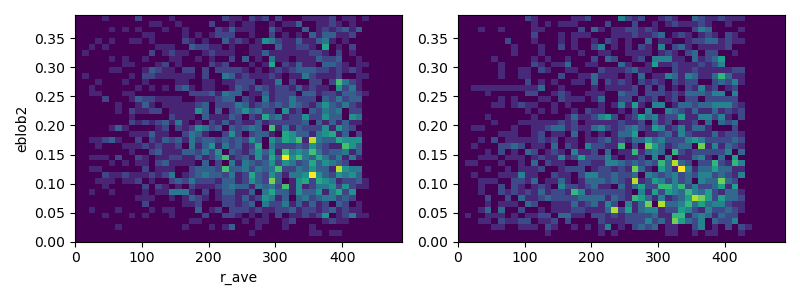

In [34]:
varx = "r_ave"
vary = "eblob2"

xbins = np.arange(0, 500, 10)
ybins = np.arange(0, 0.4, 0.01)

plt.figure(figsize=[8, 3])

plt.subplot(121)
plt.xlabel(varx)
plt.ylabel(vary)
plt.hist2d(tracks_ICS[varx], tracks_ICS[vary], bins=[xbins, ybins])

plt.subplot(122)
plt.hist2d(tracks_EP_COPPER_PLATE[varx], tracks_EP_COPPER_PLATE[vary], bins=[xbins, ybins])

plt.tight_layout();

In [19]:
tracks.columns

Index(['trackID', 'energy', 'length', 'numb_of_voxels', 'numb_of_hits',
       'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max',
       'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z', 'G4Volume'],
      dtype='object')

In [136]:
g4volume = "EP_COPPER_PLATE"
tracks = tracks_EP_COPPER_PLATE

exec(f"q_{g4volume} = []")

file_numbers = tracks.index.get_level_values("file").unique()
for file_number in file_numbers:
    
    filename = os.path.dirname(inpath.format(isotope="208Tl", g4volume=g4volume)) \
            + f"/isaura_{file_number}_{isotope}.h5"
    
    events = tracks.loc[(slice(None), file_number), :].reset_index(level=1)
    
    eventMap  = load_dst(filename, "Run", "eventMap").set_index("evt_number")
    nexus_events = eventMap.loc[events.index]
    events.loc[:, "event_id"] = nexus_events.nexus_evt
    events.set_index("event_id", inplace=True)
    
    hits      = load_dst(filename, "MC", "hits").set_index("event_id").loc[events.index]
    
    true_z = hits.groupby(level=0).apply(lambda df: (df.z*df.energy).sum()/df.energy.sum())
    
    q = (events.z_ave/true_z).values
    exec(f"q_{g4volume}.extend(q)")

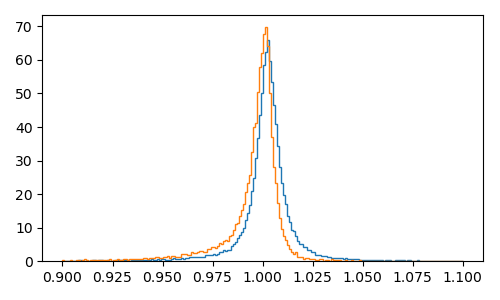

In [139]:
plt.figure(figsize=[5, 3])

bins = np.arange(0.9, 1.1, 0.001)

plt.hist(            q_ICS, bins=bins, histtype="step", density=True)
plt.hist(q_EP_COPPER_PLATE, bins=bins, histtype="step", density=True)

plt.tight_layout()

In [61]:
sel = (0.05<tracks_EP_COPPER_PLATE.eblob2)&(tracks_EP_COPPER_PLATE.eblob2<0.125)
sample = tracks_EP_COPPER_PLATE.loc[sel].sample(1)
event, file = sample.index[0]

print("Event:", event, "File:", file)
print(sample.eblob2)

Event: 75083238 File: 387
event     file
75083238  387     0.050305
Name: eblob2, dtype: float64


In [62]:
filename = os.path.dirname(inpath.format(isotope="208Tl", g4volume="EP_COPPER_PLATE")) \
            + f"/isaura_{file}_{isotope}.h5"

eventMap = load_dst(filename, "Run", "eventMap").set_index("evt_number")
hits      = load_dst(filename, "MC", "hits").set_index("event_id").loc[eventMap.loc[event].nexus_evt]
particles = load_dst(filename, "MC", "particles").set_index("event_id").loc[eventMap.loc[event].nexus_evt]

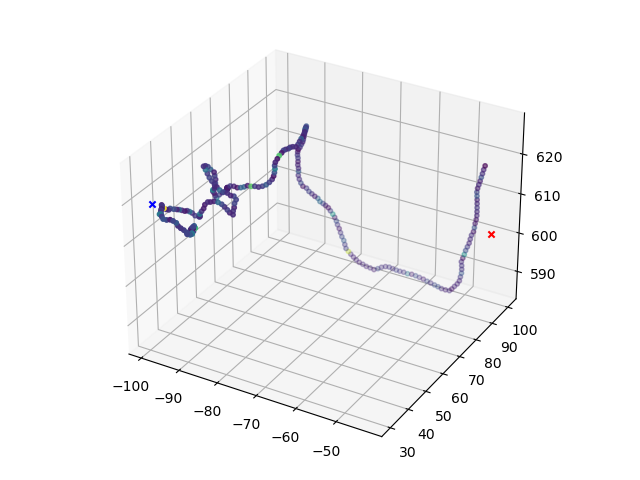

In [63]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(hits.x, hits.y, hits.z, c=hits.energy, s=10)

# ax.scatter(sample.x_ave, sample.y_ave, sample.z_ave, marker="x", color="r")

ax.scatter(sample.blob1_x, sample.blob1_y, sample.blob1_z, marker="x", color="b")
ax.scatter(sample.blob2_x, sample.blob2_y, sample.blob2_z, marker="x", color="r")

plt.tight_layout()

In [64]:
particles.loc[(particles.particle_name != "e-") | (particles.kin_energy>0.1), 
              ("particle_id", "mother_id", "particle_name", 
               "kin_energy", "creator_proc", "final_proc",
               "initial_volume", "final_volume")]

,particle_id,mother_id,particle_name,kin_energy,creator_proc,final_proc,initial_volume,final_volume
event_id,,,,,,,,
37541619,1,0,Tl208,0.000000e+00,none,RadioactiveDecay,EP_COPPER_PLATE,EP_COPPER_PLATE
37541619,4,1,e-,5.476570e-01,RadioactiveDecay,eIoni,EP_COPPER_PLATE,EP_COPPER_PLATE
37541619,3,1,anti_nu_e,7.427670e-01,RadioactiveDecay,Transportation,EP_COPPER_PLATE,WORLD
37541619,2,1,Pb208[3708.451],5.062262e-06,RadioactiveDecay,RadioactiveDecay,EP_COPPER_PLATE,EP_COPPER_PLATE
37541619,6,2,gamma,5.107393e-01,RadioactiveDecay,phot,EP_COPPER_PLATE,EP_COPPER_PLATE
37541619,20,6,gamma,8.005710e-03,phot,phot,EP_COPPER_PLATE,EP_COPPER_PLATE
37541619,19,6,e-,1.161968e-01,phot,eIoni,EP_COPPER_PLATE,EP_COPPER_PLATE
37541619,7,6,e-,3.191453e-01,compt,eIoni,EP_COPPER_PLATE,EP_COPPER_PLATE
37541619,27,7,gamma,6.036925e-02,eBrem,phot,EP_COPPER_PLATE,EP_COPPER_PLATE


In [65]:
sample.energy

event     file
75083238  387     2.009032
Name: energy, dtype: float64